# mtFAS proteomics figures   

### Import dependencies

In [1]:
import sys
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font='arial')
jakes_cmap = sns.diverging_palette(212, 61, s=99, l=77, sep=1, n=16, center='dark') #Custom aesthetics
import xpressplot as xp
import plotly
import plotly.offline as py
import plotly_express as px
%matplotlib inline

import sklearn
from sklearn import preprocessing
import scipy
import scipy.stats as stats

In [2]:
print("Pandas:",pd.__version__)
print("Numpy:",np.__version__)
print("matplotlib:",matplotlib.__version__)
print("Seaborn:",sns.__version__)
print("XPRESSplot:",xp.__version__)
print("Plotly:",plotly.__version__)
print("Scikit-learn:",sklearn.__version__)
print("scipy:",scipy.__version__)

Pandas: 1.0.2
Numpy: 1.17.4
matplotlib: 3.1.1
Seaborn: 0.10.0
XPRESSplot: 0.2.5
Plotly: 4.5.0
Scikit-learn: 0.22.1
scipy: 1.4.1


### Import data

In [3]:
# Read in csv (already has a genometric mean normalization applied)
df = pd.read_csv("./_data/mtfas_sum.csv",sep=",")
df = df[[
    'Gene Symbol',
    'GFP5-1 Sum',
    'GFP5-2 Sum',
    'GFP9-1 Sum',
    'GFP9-2 Sum',
    'Me2.14-1 Sum',
    'Me2.14-2 Sum',
    'Me3.8-1 Sum',
    'Me3.8-2 Sum',
    'O2.9-1 Sum',
    'O2.9-2 Sum']]
df = df.dropna(axis=0)

In [4]:
df_oxsm = df[[
    'Gene Symbol',
    'GFP5-1 Sum',
    'GFP5-2 Sum',
    'GFP9-1 Sum',
    'GFP9-2 Sum',
    'O2.9-1 Sum',
    'O2.9-2 Sum']]
df_mecr = df[[
    'Gene Symbol',
    'GFP5-1 Sum',
    'GFP5-2 Sum',
    'GFP9-1 Sum',
    'GFP9-2 Sum',
    'Me2.14-1 Sum',
    'Me2.14-2 Sum',
    'Me3.8-1 Sum',
    'Me3.8-2 Sum']]

df_oxsm = df_oxsm.set_index('Gene Symbol')
df_mecr = df_mecr.set_index('Gene Symbol')

In [5]:
df_oxsm.mean(axis=0)

GFP5-1 Sum    1389.076124
GFP5-2 Sum    1389.514343
GFP9-1 Sum    1389.547701
GFP9-2 Sum    1389.103826
O2.9-1 Sum    1389.088495
O2.9-2 Sum    1389.793508
dtype: float64

In [6]:
df_mecr.mean(axis=0)

GFP5-1 Sum      1389.076124
GFP5-2 Sum      1389.514343
GFP9-1 Sum      1389.547701
GFP9-2 Sum      1389.103826
Me2.14-1 Sum    1388.877011
Me2.14-2 Sum    1389.368541
Me3.8-1 Sum     1389.171612
Me3.8-2 Sum     1389.771066
dtype: float64

### SCALE GENES FOR HEATMAP    
Used a different methodology where I split up the dataframe to GFP + MECR and GFP + OXSM and then scaled datasets   
Used original sum datasheet where metrics not normalized yet   
Whether or not this works is still debatable, but if not using heatmaps for publication, not an issue   
Volcano plots are unchanged by this method as they are not scaled   

In [7]:
#Average every two cols together

df_mecr['GFP_b1'] = df_mecr[['GFP5-1 Sum','GFP5-2 Sum']].mean(axis=1)
df_mecr['GFP_b2'] = df_mecr[['GFP9-1 Sum','GFP9-2 Sum']].mean(axis=1)
df_mecr['MECR_b1'] = df_mecr[['Me2.14-1 Sum','Me2.14-2 Sum']].mean(axis=1)
df_mecr['MECR_b2'] = df_mecr[['Me3.8-1 Sum','Me3.8-2 Sum']].mean(axis=1)

df_oxsm['GFP_b1'] = df_oxsm[['GFP5-1 Sum','GFP5-2 Sum']].mean(axis=1)
df_oxsm['GFP_b2'] = df_oxsm[['GFP9-1 Sum','GFP9-2 Sum']].mean(axis=1)
df_oxsm['OXSM_b1'] = df_oxsm[['O2.9-1 Sum','O2.9-2 Sum']].mean(axis=1)

df_mecr_collapsed = df_mecr[['GFP_b1','GFP_b2','MECR_b1','MECR_b2']]
df_oxsm_collapsed = df_oxsm[['GFP_b1','GFP_b2','OXSM_b1']]

#Scale proteins
df_mecr_scaled = df_mecr_collapsed.copy()
df_mecr_scaled[df_mecr_scaled.columns] = preprocessing.scale(df_mecr_scaled[df_mecr_scaled.columns],axis=1)
print("Mecr")
print(df_mecr_scaled.mean(axis=1).head())

print("\n")
df_oxsm_scaled = df_oxsm_collapsed.copy()
df_oxsm_scaled[df_oxsm_scaled.columns] = preprocessing.scale(df_oxsm_scaled[df_oxsm_scaled.columns],axis=1)
print("Oxsm")
print(df_oxsm_scaled.mean(axis=1).head())

Mecr
Gene Symbol
Tbc1d25   -9.436896e-16
Cul4b      4.163336e-16
Dhx8      -1.026956e-15
Pgap3      9.159340e-16
Arfgef2   -8.881784e-16
dtype: float64


Oxsm
Gene Symbol
Tbc1d25    1.702342e-15
Cul4b      2.960595e-16
Dhx8       0.000000e+00
Pgap3      6.476301e-16
Arfgef2    5.366078e-15
dtype: float64


In [8]:
#Generate GFP-zeroed fold changes for heatmaps

df_mecr_logFC = df_mecr.copy()
df_mecr_logFC.index.name = None
df_mecr_logFC['gfp_mean'] = df_mecr_logFC[['GFP_b1','GFP_b2',]].mean(axis=1)
df_mecr_logFC = df_mecr_logFC[['GFP_b1','GFP_b2','MECR_b1','MECR_b2']].div(df_mecr_logFC.gfp_mean, axis=0)
df_mecr_logFC = np.log2(df_mecr_logFC)
df_mecr_logFC['base'] = df_mecr_logFC[['GFP_b1','GFP_b2']].mean(axis=1)
df_mecr_logFC = df_mecr_logFC[~df_mecr_logFC.index.duplicated()]
df_mecr_logFC = df_mecr_logFC[['GFP_b1','GFP_b2','MECR_b1','MECR_b2']].subtract(df_mecr_logFC.base, axis=0)

df_oxsm_logFC = df_oxsm.copy()
df_oxsm_logFC.index.name = None
df_oxsm_logFC['gfp_mean'] = df_oxsm_logFC[['GFP_b1','GFP_b2',]].mean(axis=1)
df_oxsm_logFC = df_oxsm_logFC[['GFP_b1','GFP_b2','OXSM_b1']].div(df_oxsm_logFC.gfp_mean, axis=0)
df_oxsm_logFC = np.log2(df_oxsm_logFC)
df_oxsm_logFC['base'] = df_oxsm_logFC[['GFP_b1','GFP_b2']].mean(axis=1)
df_oxsm_logFC = df_oxsm_logFC[~df_oxsm_logFC.index.duplicated()]
df_oxsm_logFC = df_oxsm_logFC[['GFP_b1','GFP_b2','OXSM_b1']].subtract(df_oxsm_logFC.base, axis=0)

In [9]:
df_all_fc = df_oxsm_logFC.copy()

df_all_fc['MECR_b1'] = df_mecr_logFC['MECR_b1']
df_all_fc['MECR_b2'] = df_mecr_logFC['MECR_b2']
df_all_fc.columns = [
    'GFP 1',
    'GFP 2',
    'Oxsm (O2-9)',
    'Mecr 1 (Me2-14)',
    'Mecr 2 (Me3-8)',
]

<b><u>CREATE GENE LISTS</u></b>

In [10]:
# Select proteins of interest
n_module = ['Ndufv1','Ndufv2','Ndufs1','Ndufa2','Ndufs4',
            'Ndufa12','Ndufs6','Ndufv3']
q_module = ['Ndufa6','Ndufa7','Ndufa5','Ndufs2',
            'Ndufs3','Ndufs7','Ndufs8','Ndufa9']
p_module = ['Mtnd1','Ndufa3','Ndufa8','Ndufa13','Ndufa1',
            'Mtnd3','Mtnd4l','Ndufc2','Ndufa10','Ndufs5',
            'Ndufa11','Ndufb6','Ndufb5','Ndufb10','Ndufb11',
            'Mtnd4','Ndufb4','Ndufb7','Ndufb3','Ndufb8',
            'Ndufb9','Ndufb2','Ndufs5']
pp_module = ['Mtnd1','Ndufa3','Ndufa8','Ndufa13','Ndufa1',
             'Mtnd4l','Mtnd3','Ndufc2','Ndufa10','Ndufs5',
             'Ndufa11']
pp1_module = ['Mtnd1','Ndufa3','Ndufa8','Ndufa13','Ndufa1']
pp2_module = ['Mtnd4l','Mtnd3','Ndufc2','Ndufa10','Ndufs5',
              'Ndufa11']
pd_module = ['Ndufb6','Ndufb5','Ndufb10','Ndufb11','Mtnd4',
             'Ndufb4','Ndufb7','Ndufb3','Ndufb8','Ndufb9',
             'Ndufb2']
pd1_module = ['Ndufb6','Ndufb5','Ndufb10','Ndufb11','Mtnd4',
             'Ndufb4']
pd2_module = ['Ndufb7','Ndufb3','Ndufb8','Ndufb9','Ndufb2']
complex_ii = ['Sdha','Sdhb','Sdhc']
complex_iii = ['Uqcrc2','Uqcrc1','Uqcrb','Uqcrq','Cyc1','Mt-CyB',
               'Uqcr10','Uqcrh','Uqcrfs1']
complex_iv = ['Mtco1','Cox5a','Cox5b','Cox6c','Mtco2',
              'Cox7a2','Cox7c','Cox6b1','Cox7a2l','Ndufa4',
              'Cox15']
complex_v = ['Atp5a1','Atp5b','Atp5c1','Atp5e','Atp5g2',
             'Mtatp6','Mtatp8','Atp5h','Atp5i','Atp5f1',
             'Atp5d','Atp5j2','Atp5j','Atp5l','Atp5o',
             'Atpif1']
fes_cluster = ['Lyrm4','Nfs1','Iscu']
lyr_proteins = ['Ndufa6','Ndufb9','Lyrm4']
lyr_targets = ['Sdhb','Uqcrfs1']

etc = n_module + q_module + pp_module + pd_module+ complex_ii + complex_iii + complex_iv + complex_v

In [11]:
mc = pd.read_csv("./_data/Mouse_MitoCarta2_0.csv",sep=",")

volcano_mitocarta = mc['Symbol'].tolist()

In [12]:
df_all_fc.head()

,GFP 1,GFP 2,Oxsm (O2-9),Mecr 1 (Me2-14),Mecr 2 (Me3-8)
Tbc1d25,0.054680,-0.054680,0.198497,0.057906,0.214379
Cul4b,-0.077994,0.077994,0.483798,0.291667,0.279313
Dhx8,-0.124763,0.124763,0.100311,0.357097,0.306092
Pgap3,-0.173520,0.173520,0.061596,0.136775,-0.153875
Arfgef2,0.049477,-0.049477,-0.042001,-0.000076,-0.137610


<b><u>HEATMAPS</u></b>

<Figure size 432x288 with 0 Axes>

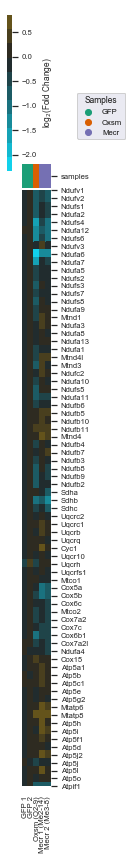

In [13]:
# Remove gene name duplicates
df_all_fc_nodups = df_all_fc[~df_all_fc.index.duplicated()]
df_all_fc_heat = df_all_fc_nodups.reindex(labels=etc,axis=0)
df_all_fc_heat = df_all_fc_heat.dropna(axis=0)

# Get sample info 
info = pd.DataFrame()
info[0] = [
    'GFP 1',
    'GFP 2',
    'Oxsm (O2-9)',
    'Mecr 1 (Me2-14)',
    'Mecr 2 (Me3-8)',
]
info[1] = [
    'GFP',
    'GFP',
    'Oxsm',
    'Mecr',
    'Mecr'
]

#Create a samples color dictionary for plots
colors = {
    'GFP':'#1b9e77',
    'Oxsm':'#d95f02',
    'Mecr':'#7570b3'}

# Generate heatmap
xp.heatmap(
    df_all_fc_heat, 
    info, 
    sample_palette=colors,
    figsize=(1.3,12),
    row_cluster=False, 
    col_cluster=False, 
    font_scale=.7,
    cbar_kws={
        'label': 'log$_2$(Fold Change)',
        'shrink': 0.2, 
        'aspect': 10})

# Add the legend manually to the current Axes.
f = lambda m,c: plt.plot([],[],marker='o', color=c, ls="none")[0]
handles = [f("s", list(colors.values())[i]) for i in range(len(list(colors.values())))]
first_legend = plt.legend(handles, list(colors.keys()), bbox_to_anchor=(15, 0.5), loc=2, borderaxespad=0., title='Samples')
ax = plt.gca().add_artist(first_legend)

ax.figure.savefig(
    "./_figures/all_FC_heatmap.pdf", 
    dpi=1800,  
    bbox_inches='tight')

<b><u>VOLCANO PLOTS</u></b>

In [14]:
# Get relevant data 
mecr_meta = {}
for x in df_mecr.columns:
    mecr_meta[x] = x[:3]

# Remove duplicates
df_mecr_nodups = df_mecr[~df_mecr.index.duplicated()]
df_mecr_nodups = df_mecr_nodups.dropna(axis=0)

mecr_meta = pd.DataFrame.from_dict(mecr_meta, orient='index', columns=['0'])
mecr_meta = mecr_meta.reset_index()
mecr_meta.columns = [0,1]

df_mecr_nodups.index.name = None

<Figure size 432x288 with 0 Axes>

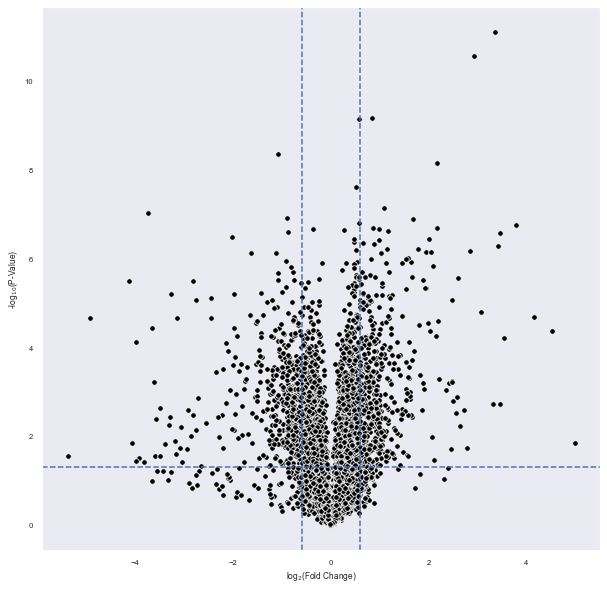

In [15]:
mecr_data = xp.volcano(
    df_mecr_nodups, 
    mecr_meta, 
    'MEC', 
    'GFP', 
    y_threshold=1.32, 
    x_threshold=[-0.59,0.59],
    return_data=True)

In [16]:
mitocarta_up = mecr_data.loc[mecr_data.index.isin(volcano_mitocarta)].loc[(mecr_data["log$_2$(Fold Change)"] > 0.59) & (mecr_data["-log$_1$$_0$(P-Value)"] > 1.31)]
print("MitoCarta up:", mitocarta_up.shape[0])

mitocarta_down = mecr_data.loc[mecr_data.index.isin(volcano_mitocarta)].loc[(mecr_data["log$_2$(Fold Change)"] < -0.59) & (mecr_data["-log$_1$$_0$(P-Value)"] > 1.31)]
print("MitoCarta down:", mitocarta_down.shape[0])

MitoCarta up: 77
MitoCarta down: 34


In [17]:
etc_up = mecr_data.loc[mecr_data.index.isin(etc)].loc[(mecr_data["log$_2$(Fold Change)"] > 0.59) & (mecr_data["-log$_1$$_0$(P-Value)"] > 1.31)]
print("ETC up:", etc_up.shape[0])

etc_down = mecr_data.loc[mecr_data.index.isin(etc)].loc[(mecr_data["log$_2$(Fold Change)"] < -0.59) & (mecr_data["-log$_1$$_0$(P-Value)"] > 1.31)]
print("ETC down:", etc_down.shape[0])

ETC up: 2
ETC down: 8


In [27]:
mecr_data.head()

,log$_2$(Fold Change),-log$_1$$_0$(P-Value)
Tbc1d25,0.137227,0.71495
Cul4b,0.283396,1.73127
Dhx8,0.326432,0.792139
Pgap3,-0.011653,0.0118838
Arfgef2,-0.068053,0.524666


In [30]:
etc_down

,log$_2$(Fold Change),-log$_1$$_0$(P-Value)
Atpif1,-0.780925,2.78225
Cox5a,-0.773029,1.39614
Cox5b,-0.854050,2.04188
Ndufs6,-0.693655,2.15438
Ndufa12,-0.846994,3.45565
Sdhb,-1.060196,3.92265
Ndufa6,-1.293170,3.51965
Ndufs4,-0.687618,1.93973


<Figure size 432x288 with 0 Axes>

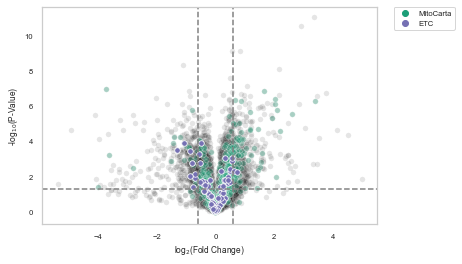

In [18]:
xp.volcano(
    df_mecr_nodups, 
    mecr_meta, 
    'MEC', 
    'GFP', 
    highlight_points=[volcano_mitocarta,etc],
    highlight_color=[
        '#1b9e77',
        '#7570b3'],
    highlight_names=[
        'MitoCarta',
        'ETC'], 
    alpha=.1, 
    alpha_highlights=[0.3,1], 
    y_threshold=1.31, 
    x_threshold=[-0.59,0.59], 
    threshold_color='grey',
    dpi=1800, 
    figsize=(6,4), 
    save_fig='./_figures/mecr_volcano.pdf', 
    whitegrid=True)

In [19]:
volcano_stem = ['Cdh15', 'Cd34', 'MyoD', 'Tnnt3', 'Tnni2',
                    'CD44', 'Tnnt2', 'Tnni1', 'Tnnc1', 'Myh1', 
                    'Mb', 'Chdh', 'Mylpf', 'Myh3', 'Acta1',
                    'Myl1', 'Myl4', 'Myl6b', 'Sorbs2', 'Csrp3',
                    'Nrap', 'Klh141', 'Ccdc141', 'Neb', 'Bin1',
                    'Ckm', 'Ckb', 'Ank1', 'Trim72', 'Itga7',
                    'Akap6', 'Dusp27']

In [20]:
stem_up = mecr_data.loc[mecr_data.index.isin(volcano_stem)].loc[(mecr_data["log$_2$(Fold Change)"] > 0.59) & (mecr_data["-log$_1$$_0$(P-Value)"] > 1.31)]
print("Differentiation up:", stem_up.shape[0])

stem_down = mecr_data.loc[mecr_data.index.isin(volcano_stem)].loc[(mecr_data["log$_2$(Fold Change)"] < -0.59) & (mecr_data["-log$_1$$_0$(P-Value)"] > 1.31)]
print("Differentiation down:", stem_down.shape[0])

Differentiation up: 0
Differentiation down: 14


<Figure size 432x288 with 0 Axes>

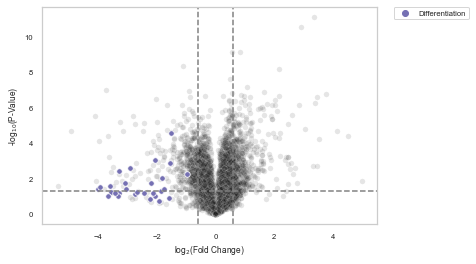

In [21]:
xp.volcano(
    df_mecr_nodups, 
    mecr_meta, 
    'MEC', 
    'GFP', 
    highlight_points=[volcano_stem],
    highlight_color=[
        '#7570b3'],
    highlight_names=[
        'Differentiation'], 
    alpha=.1, 
    alpha_highlights=[1], 
    y_threshold=1.31, 
    x_threshold=[-0.59,0.59], 
    threshold_color='grey',
    dpi=1800, 
    figsize=(6,4), 
    save_fig='./_figures/mecr_volcano_differentiation.pdf', 
    whitegrid=True)

#### Generate interactive Mecr volcano plot

<Figure size 432x288 with 0 Axes>

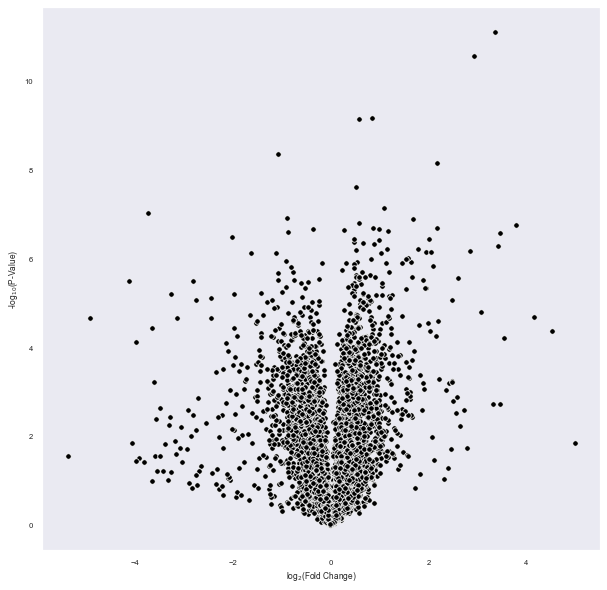

'./_figures/mecr_interactive.html'

In [22]:
# Get X and Y data
data = xp.volcano(
    df_mecr_nodups, 
    mecr_meta, 
    'MEC', 
    'GFP',  
    return_data=True)

# Prep labels
data['names'] = data.index.tolist()
label_list = []

for index, row in data.iterrows():
    
    if row[2] in etc:
        label_list.append('ETC')
    elif row[2] in volcano_mitocarta:
        label_list.append('Mitocarta')
    else:
        label_list.append('Other')

data['label'] = label_list

# Plot
sc = px.scatter(
    data,
    x='log$_2$(Fold Change)',
    y='-log$_1$$_0$(P-Value)',
    hover_name='names',
    color="label",
    color_discrete_map={
        'ETC': "#8b0000",
        'Mitocarta': "#6666ff",
        'Other': "#D3D3D3"
    },
    labels={
        'log$_2$(Fold Change)': 'log<sub>2</sub>(Fold Change)',
        '-log$_1$$_0$(P-Value)': '-log<sub>10</sub>(P-Value)'
    },
    log_x=False,
    log_y=False,
    opacity=0.7,
    width=1400,
    height=1000,
    title="Mecr proteomics")

py.offline.plot(sc, filename='./_figures/mecr_interactive.html')